## Quickstart - 2020-01-08: Getting started
Use this to step through the simulations run to create the data for Nate's upcoming submission

### Import needed packages

In [1]:
import os
from tqdm import tqdm
import sys
import seaborn as sns
import click
sys.path.append('..')

from brian2 import * # This is the meaty import
import brian_utils.postproc as bup # Import the postprocessing module
import brian_utils.model_IO as bio # Import the postprocessing module
import numpy as np
import pandas as pd 
import pickle# For saving the runs
%pylab
%matplotlib inline

WARNING    /home/choug/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed', 'sinh', 'expm1', 'arccos', 'cosh', 'sin', 'tanh', 'diagonal', 'cm', 'arcsinh', 'arange', 'power', 'zeros_like', 'log10', 'trace', 'random', 'ravel', 'exp', 'arctan', 'dot', 'numpy', 'arctanh', 'cos', 'arcsin', 'test', 'linalg', 'where', 'log', 'arccosh', 'linspace', 'ones_like', 'log1p', 'tan', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
 [py.warnings]


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Create convinience functions

In [2]:
def set_ics(neurons):
    '''
    Set the initial conditions of the state variables
    '''
    neurons.v = -58*mV
    neurons.h = 0.1
    neurons.n = 0.1
    neurons.g_syne = 0 * nS
    neurons.g_syni = 0 * nS
    neurons.g_synopioid = 0 * nS
    

# This function is not critical to understand at this point. 
def remap_inhibitory_tonic_to_quiescent(gl_vals,n_inh,t_val=0.5,q_val=1.2):
    '''
    Finds all the inhibitory tonic neurons and turns them into quiescent neurons. Takes the same number of
    excitatory quiescent neurons and turns them into tonic neurons

    This does not change the number of B/T/Q neurons in the overall population
    :param gl_vals:
    :param n_inh:
    :param t_val:
    :param q_val:
    :return:
    '''
    mask = np.where(gl_vals[:n_inh]==t_val*nS)[0]
    n_switch = len(mask)
    gl_vals[:n_inh][mask] = q_val*nS
    idx = np.where(gl_vals[n_inh:]==q_val*nS)[0]
    sub_idx = np.random.choice(idx,n_switch,replace=False)
    gl_vals[n_inh:][sub_idx] = t_val * nS

    return(gl_vals)


#### Set some run parameters
Typically these will be set as command line arguments (that is, this are commonly swept variables). 
Here we hardcode them for illustration. 
Units get added later as these values will be used in string operations (unimportant)

In [3]:
basename='test'

run_seed = 30 # Used to initialize different conditions
N = 300 # Keep this small for testing purposes
k_avg = 6 # Average synapses/neuron

pt = 0.35 # Percent intrinsically tonic neurons [0,1]
pb = 0.1 # Percent intrincially bursting neurons [0,1]
pQ = 1-pt-pb # Quiescent neurons are left over

frac_oprm1 = 0.5 # Fraction of excitatory neurons that are OPRM1+ [0,1]
frac_inh = 0.2 # Fraction of neurons that are inhibitory [0,1]

we_max = 3.5 # Excitatory synaptic strength (nS)
wi_max = 3.5 # Inhibitory synaptic strength (nS)

hyp_opioid = 4 # Opioid hyperpolarization magnitude (pA)
syn_shut = 0.5 # Opioid synaptic shutdown effect [0,1]

perturbation_dt = 10*second # Time between between perturbation steps


Set the runname and seeds, initialize a helper variable 

In [4]:
# create a unique name for this run - for saving purposes
prefix = f'{basename}_hyp{hyp_opioid:0.1f}_synshut{syn_shut:0.2f}_run{run_seed:0.0f}_pt{pt:0.1f}_pb{pb:0.2f}_syn{we_max:0.0f}'

g_nap_str = 0.3

# set random seeds for Brian's code generator, and for numpy
seed(run_seed)
np.random.seed(run_seed)

synblock = 1 # binary used to block the synapses at the end
pct_connect = (k_avg / 2) / (N - 1) # Caclulate the connection probability based on the average connection number

# Map fractions of population to integers
n_inh = int(np.ceil(N*frac_inh))
n_oprm1 = int((N-n_inh)*frac_oprm1)
n_excit = N-n_inh
print(f'Saving to: {prefix}')

Saving to: test_hyp4.0_synshut0.50_run30_pt0.3_pb0.10_syn4


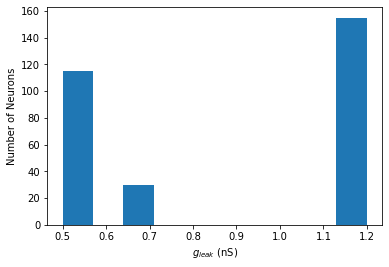

In [5]:
# The leak conductance (gl) sets the neurons' identity as (tonic, bursting, quiescent) according to the fraction of neurons for each group
gl_vals = np.random.choice(a =[0.5, 0.7, 1.2], size = N, p=[pt, pb, pQ]) * nS
# Make all inhibitory tonic neurons quiescent
gl_vals = remap_inhibitory_tonic_to_quiescent(gl_vals,n_inh,t_val=0.5,q_val = 1.2)

plt.hist(gl_vals/nS)
plt.xlabel('$g_{leak}$ (nS)')
plt.ylabel('Number of Neurons');

### Use the model IO module to load in the equations and parameters

"eqs" and "ns" get parsed into dicts

In [6]:
eqs_yaml = '../harris_eqs_oprmv1_gnap.yaml'
ns_yaml = '../harris_ns_oprmv1.yaml'
eqs = bio.import_eqs_from_yaml(eqs_yaml)
ns = bio.import_namespace_from_yaml(ns_yaml)
print(eqs.keys())

dict_keys(['neuron_eqs', 'excitatory_synapse_eqs', 'inhibitory_synapse_eqs', 'opioid_synapse_eqs', 'sensor_eqs'])


In [7]:
# For illustration, these are the imported equations that define the neuron model
print(eqs['neuron_eqs'])

 # ================ #
 # === Currents === #
 # ================ #
 I_na = g_na * m_inf**3 * (1-n) * (v-E_na) : amp
 I_k = g_k * n**4 * (v-E_k) : amp
 I_nap = g_nap * m_nap_inf * h * (v-E_na) * g_nap_drug(t) : amp
 I_l = g_l * (v-E_l) : amp

I_syne = g_syne * (v-E_excit) : amp
 I_synopioid = g_synopioid * (v-E_excit) : amp
 I_syni = g_syni * (v-E_inhib) : amp

I_opioid = damgo_sensitivity * vm_opioid(t) : amp

I_tot = I_na + I_k + I_l + I_nap + I_syne + I_syni + I_synopioid + I_opioid: amp

# ================ #
 # ==== Gating ==== #
 # ================ #

dn/dt = (n_inf-n)/tau_n : 1
 dh/dt = (h_inf-h)/tau_h : 1

# ================ #
 # = Steady State = #
 # ================ #

m_inf = 1./(1 + exp((v-vm)/sm)) : 1
 n_inf = 1./(1 + exp((v-vn)/sn)) : 1
 m_nap_inf = 1./(1 + exp((v-vmp)/smp)) : 1
 h_inf = 1./(1 + exp((v-vh)/sh)) : 1

# ================ #
 # =Time constants= #
 # ================ #
 tau_n = tau_nb/(cosh((v-vn)/(2.*sn))) : second
 tau_h = tau_hb/(cosh((v-vh)/(2.*sh))) : second


In [8]:
# And the equations that define the namespace, ie. the shared parameters:
for k,val in ns.items():
    print(f'{k} : {val}')

Cm : 2.1e-11
E_ca : 0.0
E_k : -0.085
E_l : -0.058
E_na : 0.05
E_excit : 0.0
E_inhib : -0.07
Qs : 0.0
sigma : 0.185
sh : 0.005
sm : -0.005
smp : -0.006
sn : -0.004
ssyn : -0.003
vh : -0.048
vm : -0.034
vmp : -0.04
vn : -0.029
tau_syn : 0.015
tau_nb : 0.01
tau_hb : 10.0
gamma : 0.00368
phi_m : 5.02e+17
k1 : 18200.0
k2 : 4070.0000000000005
p : 0.981
G_f0 : 36.5
kf : 121.0
G_b0 : 14.3
kb : 131.0
q : 1.45
G_a1 : 1930.0
G_a2 : 3380.0
G_d1 : 108.0
G_d2 : 11.5
G_r0 : 0.33
chr2v0 : 0.043000000000000003
chr2v1 : 0.0171
E_chr2 : 0.0
sensor_thresh : 100


## Set up the model 

In [9]:
defaultclock.dt = 0.05*ms # set the timestep -- if you get NaNs in your runs, decrease this (smaller timesteps)

In [10]:
# the cpp_standalone mode gives you massive speed up, no interactivity. Use it when working, but it won't work here
run_cpp = False
if run_cpp:
    print('Setting the device')
    set_device('cpp_standalone',clean=True,build_on_run=False)
    prefs.devices.cpp_standalone.openmp_threads = 4 # For multithreading
    

Set up the full neuron population

In [11]:
neurons = NeuronGroup(N, eqs['neuron_eqs'],
                      threshold='v>=-20*mV',
                      refractory=2 * ms,
                      method='rk4',
                      namespace=ns)
neurons

NeuronGroup(clock=Clock(dt=50. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

### Set up synapses.

In [12]:
print('Setting up synapses...')

# Set subpopulations 
Pi = neurons[:n_inh] # inhibitory neurons
Pe_oprm1 = neurons[n_inh:n_oprm1+n_inh] # Excitatory oprm1+ neurons
Pe = neurons[n_oprm1+n_inh:] # Excitatory oprm1- neurons

# Connect the subpopulations to the entire population - note, the different synapses affect different variables in the post-synaptic neuron
# con_oprm1 affects the gsyn_opioid in the post-synaptic cell and con_e affects gsyn_e 
con_e = Synapses(Pe, neurons, model=eqs['excitatory_synapse_eqs'], method='exponential_euler', namespace=ns)
con_oprm1 = Synapses(Pe_oprm1, neurons, model=eqs['opioid_synapse_eqs'], method='exponential_euler', namespace=ns)
con_i = Synapses(Pi, neurons, model=eqs['inhibitory_synapse_eqs'], method='exponential_euler', namespace=ns)


Setting up synapses...


In [19]:
Pe

<Subgroup 'neurongroup_subgroup_2' of 'neurongroup' from 180 to 300>

In [13]:
# Use the run seed to reset the random number generator and create the network topology - 
# this allows for repetition of the same network topology based on the run seed provided
np.random.seed(run_seed)
seed(run_seed)
con_i.connect(p=pct_connect)
con_e.connect(p=pct_connect)
con_oprm1.connect(p=pct_connect)

In [27]:
con_e.i
con_e.j
con_oprm1.j

<synapses_1.j: array([ 70,  88, 202, 223, 272, 287,  26, 130,  56, 179, 295,  59, 288,
       185, 217, 253, 265, 271,  12,  60,  91, 144, 284, 204, 243, 116,
       121, 163, 176, 150, 182,   7, 201, 139, 145, 148, 178,  82, 169,
       179, 212, 128, 282,  74, 185, 197, 228, 163, 178, 189, 239, 255,
       266, 289, 297, 176,  41,  60, 179, 242, 285,  18, 102, 200, 223,
        20, 159, 185,  93, 101, 229, 214, 290,  18,  72,  74,  92, 209,
       231, 235, 110, 166,  37,  47,   6, 115, 157, 191, 299,  88, 130,
       170,  74, 158, 237, 159,  59, 119, 148, 269,  61,  88, 251, 280,
       293, 220,  73,  18, 157,  27,  59,  90, 120, 140, 149, 203,  56,
       127, 222,  25,  64, 111, 192, 282, 297,   3,  96, 109, 216, 229,
       276, 168, 270,  39,  60,  80, 192, 210,   1,   2,  94, 147, 235,
       289,  15,  17,  27,  59,  62, 104, 164, 278, 240,  28, 122, 130,
       171, 280,  10,  61, 213, 207, 292,   4,  14,  97, 116, 227, 234,
        45,  47,  65,  52, 125, 168, 238, 241,  2


### Set up integrator (for use in the phase-driven optogenetic stimulus)
Kept for posterity, not used, but you need to run this...

In [28]:
sensor_int = NeuronGroup(1, eqs['sensor_eqs'], method='rk4')

# incoming connections
con_in = Synapses(neurons, sensor_int, on_pre='v += 1')
con_in.connect()  # fully connected

# outgoing connections
neurons.sensor = linked_var(sensor_int, 'v')
sensor_int.v = 0.


### Set up cell specific parameters 


In [15]:
set_ics(neurons)

# again reinit the random seed to make the runs repeatable
seed(run_seed)
np.random.seed(run_seed)

# Add some randomness to the gl,gnap values
gl_vals = gl_vals + np.random.normal(0,.05,N) * nS
gnap_vals = 0.8 * nS + np.random.normal(0,.05,N) * nS

# Assign the values to the neurons
neurons.g_l = gl_vals
neurons.g_k = 11.2 * nsiemens
neurons.g_na = 28. * nsiemens
neurons.g_nap = gnap_vals
# Make all neurons damgo-insensitive, then make the OPRM1 neurons damgo sensitive (these are multipliers on the gsynopioid variable in the neuron equations)
neurons.damgo_sensitivity = 0
Pe_oprm1.damgo_sensitivity = 1

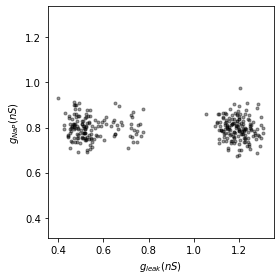

In [16]:
# os.mkdir(basename)
plt.figure(figsize=(4,4))
plt.plot(gl_vals/nS,gnap_vals/nS,'k.',alpha=0.4)
plt.tight_layout()
plt.xlabel('$g_{leak} (nS)$')
plt.ylabel('$g_{NaP} (nS)$')
plt.axis('equal')
plt.tight_layout()
#plt.savefig('cloud.png')
#plt.savefig(f'{basename}/{basename}_g_nap_g_leak.png')

### Set up monitors for saving the data

In [17]:
# Only record the voltage for 15 neurons
statemon = StateMonitor(neurons, variables=['v','h','n','g_syne','g_syni','g_synopioid'],
                        record=np.arange(0, N, N / 15).astype('int'), dt=0.5 * ms)

# Record the population spike rate
ratemon = PopulationRateMonitor(neurons)
# Record the population spike times
spikemon = SpikeMonitor(neurons)

### Set up perturbations

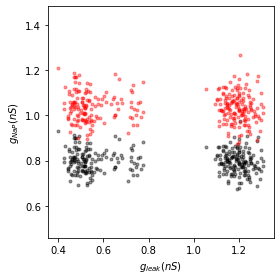

In [29]:
# This is a little confusing. Here we are using timed-arrays to turn on and off different perturbations.

# Each value will be applied for the duration of perturbation_dt. (Change these sequences to modify the pertubation timing and duration)
# op_vals =   np.array([0,0,0,0,0,1,1,0,1,1]) # When are opioids applied?
# op_vals  =   np.array([0,0,1,1,0,0,0,0,1,1]) 
# # g_nap_str = 1.2 # 0.5 < g_nap_str < 1.5
# g_nap_mult= g_nap_str * np.array([0,0,0,0,0,0,1,1,1,1]) + 1 # multiply by g_nap_str to change strength of effect

op_vals  =               np.array([0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1]) # When are opioids applied?
g_nap_mult = g_nap_str * np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1]) + 1 # multiply by g_nap_str to change strength of effect

we =                     np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0]) # When are excitatory synapses active? (always)
wi =                     np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0]) # When are inhibitory synapses active
    

# Map to a Timed Array with the magnitude scaled by the run parameter (e.g. we_max)
we = TimedArray(we*we_max*nS,dt=perturbation_dt)
wi = TimedArray(wi*wi_max*nS,dt=perturbation_dt)

# Map the opioid effects to timed arrays
g_nap_drug = TimedArray(g_nap_mult, dt = perturbation_dt)
vm_opioid = TimedArray(op_vals*hyp_opioid*pA,dt = perturbation_dt) # The hyperpolarization effect
we_opioid = TimedArray((1-op_vals*syn_shut)*we_max*nS,dt = perturbation_dt) # The synaptic shutdown effect

# make the runtime as long as all the perturbations
runtime = len(op_vals)*perturbation_dt

#plot perturbed gnap vs gleak
modified_gnap = (g_nap_str + 1) * gnap_vals
plt.figure(figsize=(4,4))
plt.plot(gl_vals/nS, gnap_vals/nS, 'k.', alpha = 0.4)
plt.plot(gl_vals/nS, modified_gnap/nS, 'r.', alpha=0.4)
plt.tight_layout()
plt.xlabel('$g_{leak} (nS)$')
plt.ylabel('$g_{NaP} (nS)$')
plt.axis('equal')
plt.tight_layout()
#plt.savefig(f'{prefix}/{prefix}_mod_gnap_gleak.png')

### Visualize the perturbations

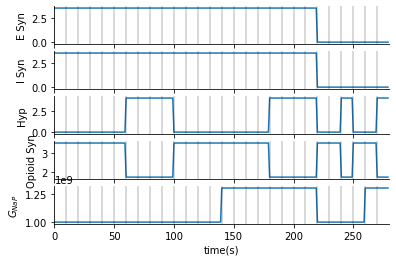

In [33]:
tt = np.arange(0,runtime,1)*second
tlines = np.arange(0,runtime,perturbation_dt) # these show you every "perturbation_dt" time period

f,ax = plt.subplots(nrows=5,sharex=True)

ax[0].plot(tt,we(tt)/nS)
ax[1].plot(tt,wi(tt)/nS)
ax[2].plot(tt,vm_opioid(tt)/pA)
ax[3].plot(tt,we_opioid(tt)/nS)
ax[4].plot(tt,g_nap_drug(tt)/nS)

ax[0].set_ylabel('E Syn')
ax[1].set_ylabel('I Syn')
ax[2].set_ylabel('Hyp')
ax[3].set_ylabel('Opioid Syn')
ax[4].set_ylabel(r'$G_{NaP}$ (nS)')

ax[4].set_xlim(0,280)


plt.xlabel('time(s)')
for ii in range(5):
    for ll in tlines:
        ax[ii].axvline(ll,color='k',alpha=0.2)
sns.despine()


## Run the network!

In [30]:
seed(run_seed)
np.random.seed(run_seed)
# lets shorten the runtime so we can get to the end
# runtime = 60*second
# =============== #
# Run baseline
# =============== #
print('Setting up run...may take some time')
net = Network(collect())
net.run(runtime, report='text')

# =============== #
# Run intrinsic (i.e. block all synapses)
# =============== #
print('Shutting off synapses...')
synblock = 0
net.run(20*second,report='text')

#====================== #
# Build
#====================== #
if run_cpp:
    device.build(directory=f'./{idx:04.0f}', compile=True, run=True, debug=False)

Setting up run...may take some time
Starting simulation at t=0. s for a duration of 200. s
0.6271 (0%) simulated in 10s, estimated 53m 0s remaining.
1.3279 (0%) simulated in 20s, estimated 49m 53s remaining.
1.9315499999999999 (0%) simulated in 30s, estimated 51m 17s remaining.
2.63925 (1%) simulated in 40s, estimated 49m 51s remaining.
3.2775 (1%) simulated in 50s, estimated 50m 1s remaining.
3.8102500000000004 (1%) simulated in 1m 0s, estimated 51m 30s remaining.
4.28015 (2%) simulated in 1m 10s, estimated 53m 21s remaining.
4.7839 (2%) simulated in 1m 20s, estimated 54m 25s remaining.
5.386950000000001 (2%) simulated in 1m 30s, estimated 54m 12s remaining.
6.082 (3%) simulated in 1m 40s, estimated 53m 9s remaining.
6.716550000000001 (3%) simulated in 1m 50s, estimated 52m 46s remaining.
7.3748000000000005 (3%) simulated in 2m 0s, estimated 52m 15s remaining.
7.859250000000001 (3%) simulated in 2m 10s, estimated 52m 59s remaining.
8.5576 (4%) simulated in 2m 20s, estimated 52m 12s re

## Save the results

In [31]:
# Standardizing this could be good?
save_tgl = False
if save_tgl:
    states = net.get_states()
    states['ns'] = ns
    states['eqs'] = eqs
    states['n_inh'] = n_inh
    states['n_oprm1'] = n_oprm1
    states['hyp'] = hyp_opioid
    states['syn_shut'] = syn_shut
    states['run_seed'] = run_seed
    states['perturbation_dt'] = perturbation_dt
    states['we_opioid'] = we_opioid.values
    states['vm_opioid'] = vm_opioid.values
    states['we'] = we.values
    states['wi'] = wi.values

    with open(savename,'wb') as fid:
        pickle.dump(states,fid)

# this deletes all the temporary files if using CPP mode
if run_cpp:
    device.delete

## Do some preliminary plotting

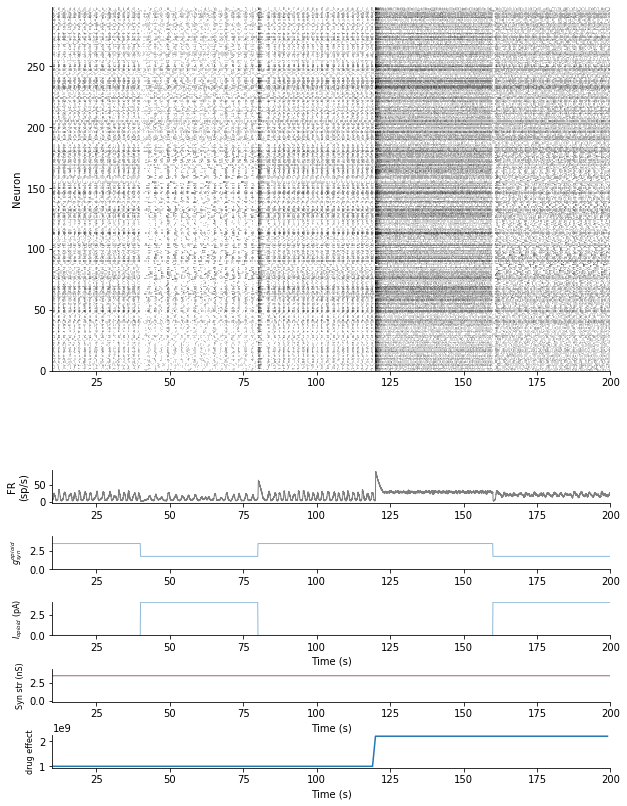

In [42]:
#### Compute the binned spike trains and population rates
raster, cell_id, bins = bup.bin_trains(spikemon.t, spikemon.i, neurons.N, max_time=statemon.t[-1])
binsize = 10 * ms
smoothed_pop_rate = ratemon.smooth_rate('gaussian', binsize)

# =================== #
# Plot
# =================== #
f = plt.figure(figsize=(10, 14))
g = f.add_gridspec(12, 1)

# Plot raster
ax0 = f.add_subplot(g[:6, 0])
plt.pcolormesh(bins, cell_id, raster / (binsize / second), cmap='gray_r')
plt.ylabel('Neuron')

# Plot population rate
ax1 = f.add_subplot(g[7, 0], sharex=ax0)
plt.plot(ratemon.t, smoothed_pop_rate, 'k', linewidth=1,alpha=0.5)
plt.ylabel('FR\n(sp/s)')

# Plot DAMGO
ax1 = f.add_subplot(g[8, 0], sharex=ax0)
tvec = np.arange(0,runtime/second,.1)*second
ax1.plot(tvec,we_opioid(tvec)/nS, 'tab:blue', linewidth=1,alpha=0.5)
ax1.set_ylim(0,we_max+1)
# plt.ylabel('DAMGO (percent max block)')
ax1.set_ylabel('$g_{syn}^{opioid}$',fontsize=8)

ax2 = f.add_subplot(g[9, 0], sharex=ax0)
tvec = np.arange(0,runtime/second,.1)*second
ax2.plot(tvec,vm_opioid(tvec)/pA, 'tab:blue', linewidth=1,alpha=0.5)
ax2.set_ylim(0,hyp_opioid)
# plt.ylabel('DAMGO (percent max block)')
ax2.set_ylabel('$I_{opioid}$ (pA)',fontsize=8)
ax2.set_xlabel('Time (s)')

# Plot we/wi
ax3 = f.add_subplot(g[10, 0], sharex=ax0)
tvec = np.arange(0,runtime/second,.1)*second
ax3.plot(tvec,we(tvec)/nS, 'tab:blue', linewidth=1,alpha=0.5)
ax3.plot(tvec,wi(tvec)/nS, 'tab:red', linewidth=1,alpha=0.5)
ax3.set_ylim(-.1,we_max+1)
# plt.ylabel('DAMGO (percent max block)')
ax3.set_ylabel('Syn str (nS)',fontsize=8)
ax3.set_xlabel('Time (s)')

# Plot drug perturbation
ax4 = f.add_subplot(g[11,0], sharex=ax0)
ax4.plot(tt,g_nap_drug(tt)/nS)
tvec = np.arange(0,runtime/second,.1)*second
ax4.set_ylabel('drug effect',fontsize=8)
ax4.set_xlabel('Time (s)')

# Cleanup and save
sns.despine()
# plt.xlim(5,13)
#plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=1.0)
plt.xlim(10,runtime/second)
plt.savefig('g_nap_network12.png')

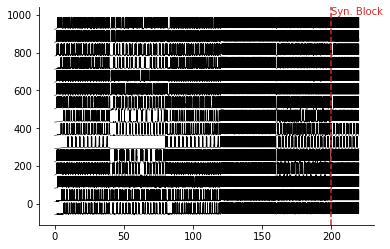

In [43]:
for ii in range(15):
    plt.plot(statemon.t,statemon.v[ii]/mV+70*ii,'k',lw=0.5)
sns.despine()
plt.axvline(runtime/second,c='tab:red',ls='--')
plt.text(runtime/second,1000,'Syn. Block',c='tab:red')
plt.savefig('net1_synblock_12.png')

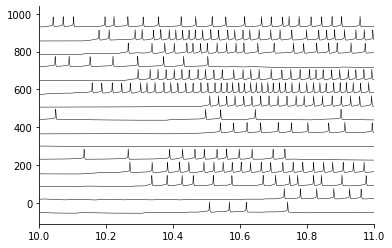

In [44]:
for ii in range(15):
    plt.plot(statemon.t,statemon.v[ii]/mV+70*ii,'k',lw=0.5)
sns.despine()
plt.xlim(10,11)
plt.savefig('net1fig_str12.png')

WARNING    /Users/grantchou3/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
 [py.warnings]
WARNING    /Users/grantchou3/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


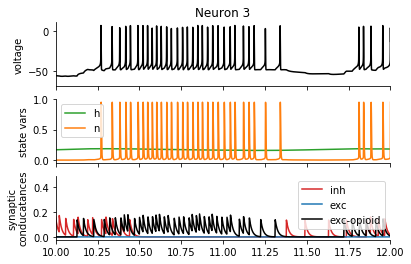

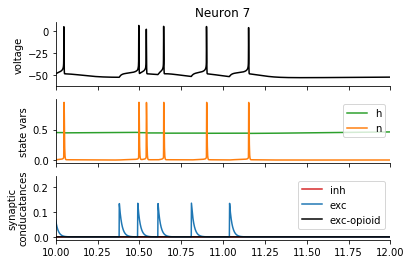

In [45]:
# plot a close up of  couple neurons 
for nn in [3,7]:
    f,ax = plt.subplots(nrows=3,sharex=True)
    ax[0].plot(statemon.t,statemon.v[nn]/mV,c='k')
    ax[0].set_ylabel("voltage")

    ax[1].plot(statemon.t,statemon.h[nn],c='tab:green')
    ax[1].plot(statemon.t,statemon.n[nn],c='tab:orange')
    ax[1].set_ylabel("state vars")
    plt.sca(ax[1])
    plt.legend(['h','n'])

    ax[2].plot(statemon.t,statemon.g_syni[nn]/nS,c='tab:red')
    ax[2].plot(statemon.t,statemon.g_syne[nn]/nS,c='tab:blue')
    ax[2].plot(statemon.t,statemon.g_synopioid[nn]/nS,c='k')

    ax[2].set_ylabel("synaptic\nconducatances")
    plt.sca(ax[2])

    plt.legend(['inh','exc','exc-opioid'])
    plt.xlim(10,12)
    ax[0].set_title(f'Neuron {nn}')

    sns.despine()
    #plt.savefig('net1_single_neurons_str12.png')